# **TMDB 5000 Movie Rating Prediction**  
### **Ming-Kai Liu**,  **Chao-Jung Lai**,   **Eddy Chu**,   **Yen-Ting Lee**

![My plot](img/project-cover-page.png)





## **1. Introduction**
### **This is a rate prediction task.**


We use the **TMDB Movie Metadata** dataset from Kaggle, which contains over 5,000 films with metadata such as genres, keywords, cast, crew, budgets, revenues, text descriptions, and popularity statistics.  
Our goal is to **predict the movie’s average user rating (`vote_average`)**, a continuous value between 0 and 10.

This is a **regression task**, evaluated using **RMSE** and **MAE** on a held-out test set.


### Task Summary


We aim to predict **`vote_average`** from structured metadata and text features.

Our baselines and models include:

- **Baseline:** global average rating per genre  
- Feature-engineered similarity models  
- Text-based representations  
- LLM-based regression models  


### Model Evaluation

We assess the validity of our predictions through:

1. **Held-out test metrics**  
   - RMSE and MAE indicate how close predictions are to true ratings.  
   - Lower values → better generalization.

2. **Baseline comparison**  
   - Models must outperform the **global genre-average predictor** to be considered meaningful.

3. **Error analysis**  
   - Reviewing films with large prediction errors to understand failures and potential noise.




## **2. Data Analysis**
### Context

The dataset used in this project is the **TMDB Movie Metadata** dataset from Kaggle. It contains movie-level information originally sourced from *The Movie Database (TMDb)*, a community-driven platform where users contribute and maintain data about films, TV shows, cast, and crew.

The dataset was collected by compiling publicly available metadata from TMDb's API and organizing it into structured CSV files (movies and credits). It includes information such as movie titles, genres, budgets, revenues, descriptions, popularity metrics, cast lists, and crew details.

### Discussion — Data Processing
We cleaned numerical fields, standardized text, and parsed JSON-like cast lists into structured arrays.  
- For **similarity models**, we extracted the **top-K billed cast** for each movie and identified the **top-N most frequent actors** in the dataset, forming a **one-hot vector** (length N) indicating whether a movie includes each top actor.   We applied the same idea to *overview* text: tokenize, keep the top-N frequent tokens, and represent each movie with a sparse binary vector.  
- For **LLM-based models**, these curated cast lists and summaries were incorporated directly into the **prompt**, letting the model reason over structured (top-K cast) and unstructured (overview) information without extra feature engineering.


### Code (Exploration and analysis)

In [1]:
import pandas as pd
import numpy as np

df_credits=pd.read_csv('dataset/tmdb_5000_credits.csv')
df=pd.read_csv('dataset/tmdb_5000_movies.csv')

#### Raw Data Overview:

In [2]:
df_credits.columns = ['id','title','cast','crew']
df= df.merge(df_credits,on='id')
df['title'] = df['title_x']
df = df.drop(columns=['title_x', 'title_y'])
print("Dataset overview (before cleaning):")
df.head()

Dataset overview (before cleaning):


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,cast,crew,title
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",Avatar
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Pirates of the Caribbean: At World's End
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",Spectre
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",The Dark Knight Rises
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",John Carter


In [3]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'vote_average', 'vote_count',
       'cast', 'crew', 'title'],
      dtype='object')

In [4]:
print("df is unique: ", df['id'].is_unique)
print("df has", len(df), "rows, with", df['id'].nunique(), "unique IDs")
print("df has", df['id'].duplicated().sum(), "duplicate IDs")

if df['id'].duplicated().any():
    print("\ndf duplicate IDs:")
    print(df[df['id'].duplicated(keep=False)].sort_values('id'))


df is unique:  True
df has 4803 rows, with 4803 unique IDs
df has 0 duplicate IDs


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from collections import Counter

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
print(f"Shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))
print(f"\nTarget variable (vote_average) statistics:")
print(df['vote_average'].describe())


Shape: (4803, 22)

Missing values:
homepage                3091
tagline                  844
overview                   3
runtime                    2
release_date               1
revenue                    0
crew                       0
cast                       0
vote_count                 0
vote_average               0
status                     0
spoken_languages           0
budget                     0
genres                     0
production_countries       0
production_companies       0
popularity                 0
original_title             0
original_language          0
keywords                   0
id                         0
title                      0
dtype: int64

Target variable (vote_average) statistics:
count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64


#### Data Cleaning:
We perform several data cleaning steps to prepare the dataset. First, we drop the `homepage` and `tagline` columns as they contain too many missing values and are not essential for our analysis. Next, we remove rows with missing `overview` since this field is crucial for our model. For `runtime`, we fill missing values with the mean runtime. Finally, we convert `release_date` to datetime format and fill any missing dates with the median release date.


In [7]:
print(f"Original shape: {df.shape}")

df = df.drop(columns=['homepage', 'tagline'])
print(f"After dropping homepage and tagline: {df.shape}")

df = df.dropna(subset=['overview'])
print(f"After dropping rows with missing overview: {df.shape}")

runtime_mean = df['runtime'].mean()
df['runtime'] = df['runtime'].fillna(runtime_mean)
print(f"Filled {df['runtime'].isnull().sum()} missing runtime values with mean: {runtime_mean:.2f}")

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
release_date_median = df['release_date'].median()
df['release_date'] = df['release_date'].fillna(release_date_median)
print(f"Filled {df['release_date'].isnull().sum()} missing release_date values with median: {release_date_median}")

print(f"\nFinal shape: {df.shape}")
print(f"\nRemaining missing values:")
remaining_missing = df.isnull().sum()
print(remaining_missing[remaining_missing > 0])


Original shape: (4803, 22)
After dropping homepage and tagline: (4803, 20)
After dropping rows with missing overview: (4800, 20)
Filled 0 missing runtime values with mean: 106.88
Filled 0 missing release_date values with median: 2005-09-30 00:00:00

Final shape: (4800, 20)

Remaining missing values:
Series([], dtype: int64)


#### Create Features:
We create several numerical and categorical features from the JSON-formatted columns. First, we extract count features: `num_genres`, `num_keywords`, `num_production_companies`, `num_production_countries`, `num_spoken_languages`, `num_cast`, and `num_crew` by counting items in each list. Next, we extract the `director` name from the crew list where job equals "Director". Finally, we create `top_cast` which contains the names of the top 5 cast members. These features help capture the scale and key personnel information of each movie.


In [9]:
def safe_parse_json(x):
    if pd.isna(x) or x == '':
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df['num_genres'] = df['genres'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_keywords'] = df['keywords'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_cast'] = df['cast'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)
df['num_crew'] = df['crew'].apply(lambda x: len(safe_parse_json(x)) if safe_parse_json(x) else 0)

def get_director(crew_list):
    if not crew_list:
        return []
    directors = []
    for person in crew_list:
        if person.get('job') == 'Director':
            directors.append(person.get('name'))
    return directors

df['director'] = df['crew'].apply(lambda x: get_director(safe_parse_json(x)))

def get_top_cast(cast_list, n=5):
    if not cast_list:
        return []
    return [actor.get('name', '') for actor in cast_list[:n]]

df['top_cast'] = df['cast'].apply(lambda x: get_top_cast(safe_parse_json(x)))

print(f"Total features: {df.shape[1]}")


Total features: 29


#### Exploratory Data Analysis - Genre Analysis:
We extract the genre list for each movie and analyze the relationship between genres and average ratings. This helps us understand which genres tend to receive higher ratings in the dataset.


=== Average vote_average by Genre ===
genre
History            6.719797
War                6.713889
Drama              6.388197
Music              6.355676
Foreign            6.352941
Animation          6.341453
Documentary        6.285185
Crime              6.274138
Romance            6.207718
Mystery            6.183908
Western            6.178049
Adventure          6.156962
Fantasy            6.096698
Family             6.029630
Thriller           6.010989
Science Fiction    6.005607
Action             5.989515
Comedy             5.945587
TV Movie           5.662500
Horror             5.626590
Name: vote_average, dtype: float64


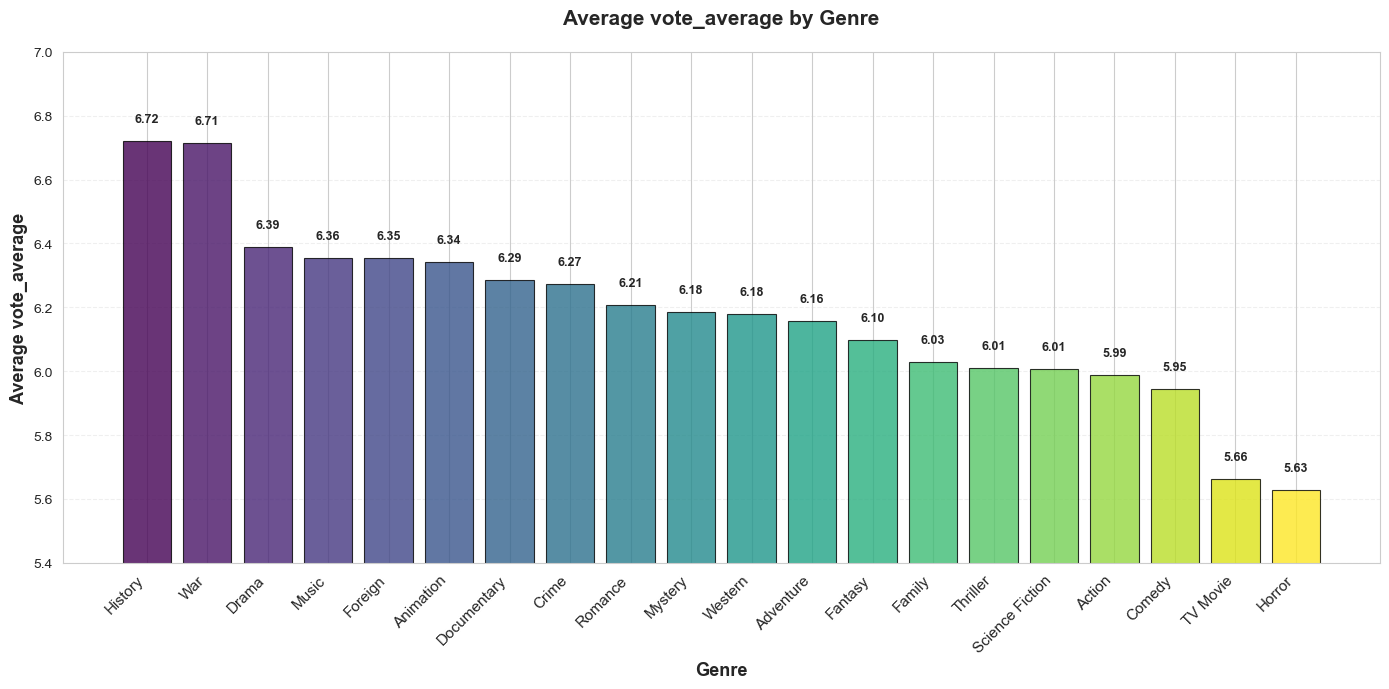

In [10]:
def extract_genres(genres_str):
    genres_list = safe_parse_json(genres_str)
    return [g.get('name', '') for g in genres_list if isinstance(g, dict)]

df['genre_list'] = df['genres'].apply(extract_genres)

all_genres = []
genre_votes = []

for idx, row in df.iterrows():
    genres = row['genre_list']
    vote = row['vote_average']
    for genre in genres:
        all_genres.append(genre)
        genre_votes.append((genre, vote))

genre_df = pd.DataFrame(genre_votes, columns=['genre', 'vote_average'])
genre_avg = genre_df.groupby('genre')['vote_average'].mean().sort_values(ascending=False)

print("=== Average vote_average by Genre ===")
print(genre_avg)

# Create a more visually appealing plot
plt.figure(figsize=(14, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_avg)))
bars = plt.bar(range(len(genre_avg)), genre_avg.values, color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, genre_avg.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(range(len(genre_avg)), genre_avg.index, rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Genre', fontsize=13, fontweight='bold')
plt.ylabel('Average vote_average', fontsize=13, fontweight='bold')
plt.title('Average vote_average by Genre', fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(5.4, 7.0)
plt.tight_layout()
plt.show()

#### Exploratory Data Analysis - Language Analysis:
We analyze the relationship between original language and average ratings. We only consider languages with at least 10 movies to ensure statistical reliability.


=== Average vote_average by Original Language (min 10 movies) ===
   language  avg_vote  movie_count
17       ja  7.050000           16
16       it  7.007692           13
18       ko  6.672727           11
8        es  6.659375           32
2        cn  6.500000           12
10       fr  6.430000           70
27       ru  6.354545           11
36       zh  6.300000           27
5        de  6.284615           26
7        en  6.067029         4504
12       hi  6.010526           19


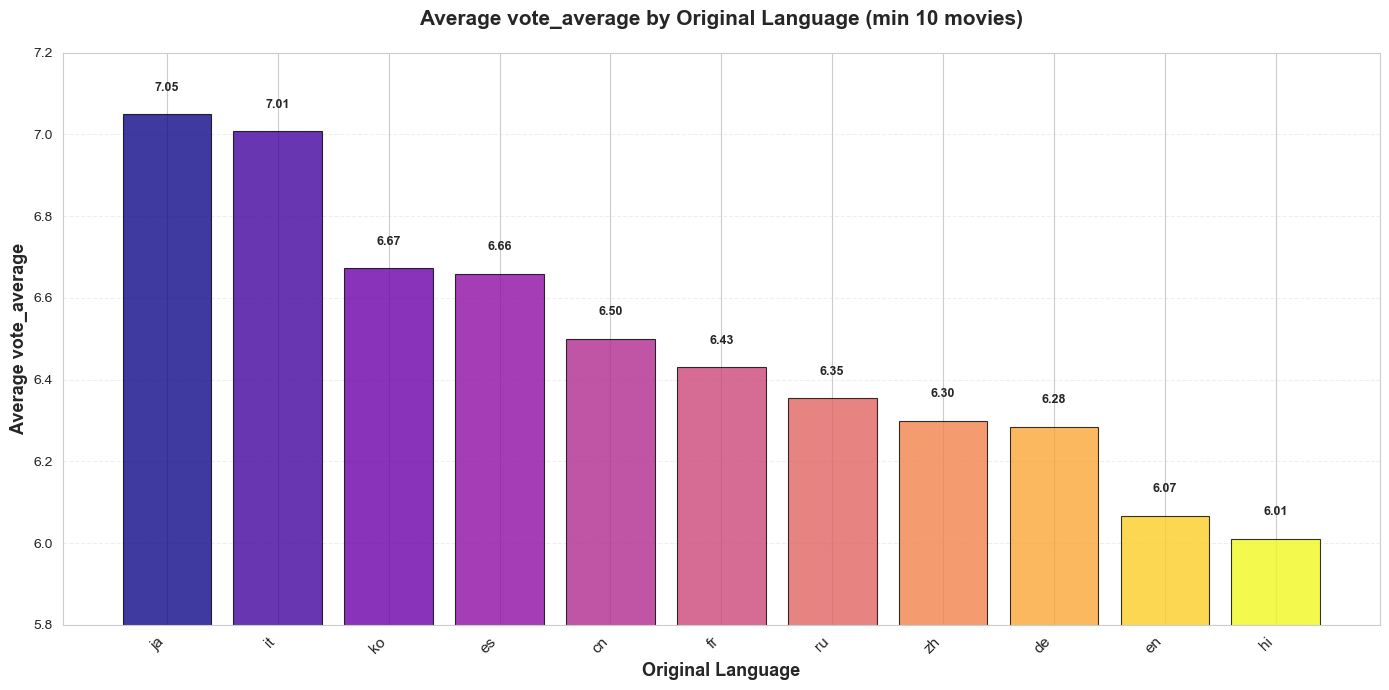

In [12]:
language_stats = df.groupby('original_language').agg({
    'vote_average': ['mean', 'count']
}).reset_index()
language_stats.columns = ['language', 'avg_vote', 'movie_count']
language_stats = language_stats[language_stats['movie_count'] >= 10]  # Languages with at least 10 movies
language_stats = language_stats.sort_values('avg_vote', ascending=False)

print("=== Average vote_average by Original Language (min 10 movies) ===")
print(language_stats)

# Create a more visually appealing plot
plt.figure(figsize=(14, 7))
colors = plt.cm.plasma(np.linspace(0, 1, len(language_stats)))
bars = plt.bar(range(len(language_stats)), language_stats['avg_vote'],
               color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, language_stats['avg_vote'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(range(len(language_stats)), language_stats['language'],
           rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Original Language', fontsize=13, fontweight='bold')
plt.ylabel('Average vote_average', fontsize=13, fontweight='bold')
plt.title('Average vote_average by Original Language (min 10 movies)',
          fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(5.8, 7.2)
plt.tight_layout()
plt.show()


#### Exploratory Data Analysis - Pearson Correlation Analysis:
We compute Pearson correlation coefficients between numerical features and the target variable `vote_average`. This helps identify which features have linear relationships with movie ratings and their strength of association.

=== Pearson Correlation with vote_average (sorted) ===
vote_average                1.000000
runtime                     0.375378
num_keywords                0.289158
popularity                  0.274366
num_cast                    0.230449
revenue                     0.197431
num_crew                    0.170978
num_production_companies    0.153951
num_spoken_languages        0.137813
num_production_countries    0.126074
budget                      0.092902
num_genres                  0.085024
Name: vote_average, dtype: float64


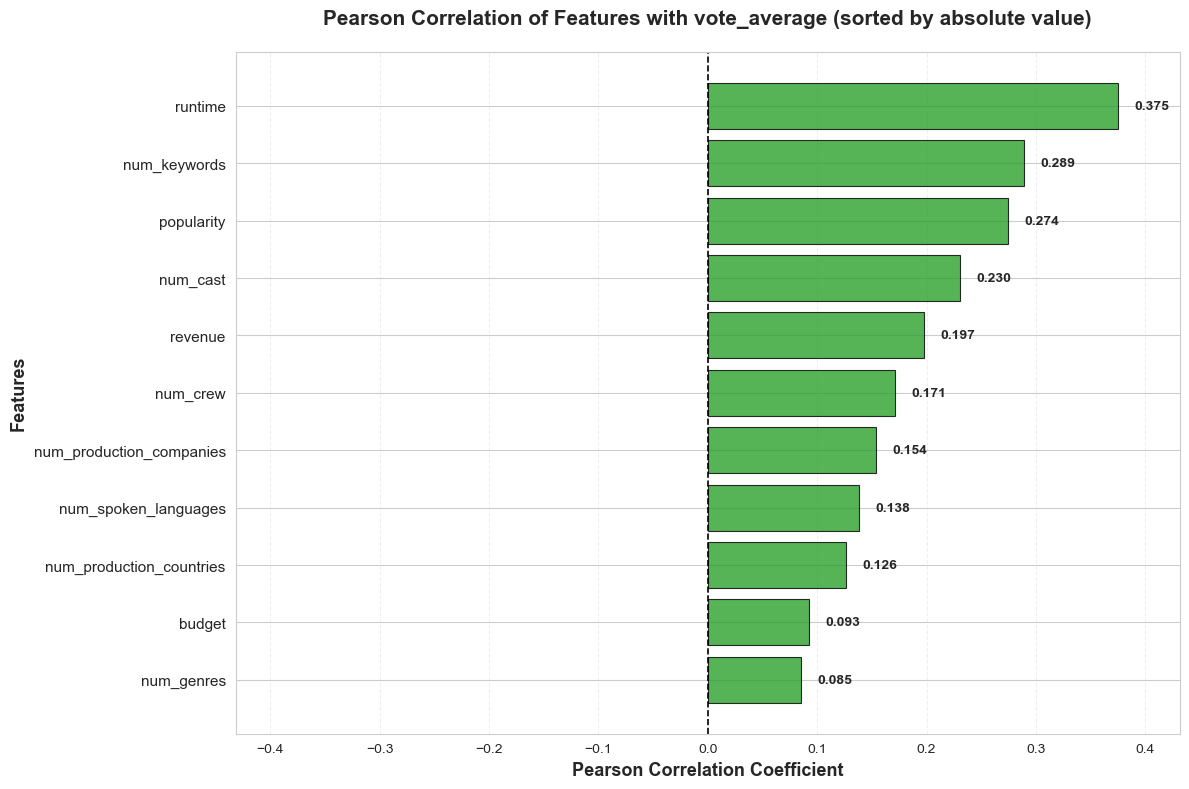

In [13]:
numerical_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'num_genres', 'num_keywords', 'num_production_companies',
                      'num_production_countries', 'num_spoken_languages',
                      'num_cast', 'num_crew', 'vote_average']

corr_df = df[numerical_features].corr() # pearson correlation

vote_corr = corr_df['vote_average'].sort_values(ascending=False)
print("=== Pearson Correlation with vote_average (sorted) ===")
print(vote_corr)

# Create a more visually appealing plot - sort by absolute value to show strongest correlations first
vote_corr_without_self = vote_corr.drop('vote_average')
# Sort by absolute value descending, then reverse for barh (strongest on top)
vote_corr_sorted = vote_corr_without_self.reindex(vote_corr_without_self.abs().sort_values(ascending=False).index)[::-1]

plt.figure(figsize=(12, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in vote_corr_sorted.values]
bars = plt.barh(range(len(vote_corr_sorted)), vote_corr_sorted.values,
                color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, vote_corr_sorted.values)):
    plt.text(value + (0.015 if value >= 0 else -0.015), bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center',
             fontsize=10, fontweight='bold')

plt.yticks(range(len(vote_corr_sorted)), vote_corr_sorted.index, fontsize=11)
plt.xticks(fontsize=10)
plt.xlabel('Pearson Correlation Coefficient', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('Pearson Correlation of Features with vote_average (sorted by absolute value)',
          fontsize=15, fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.2)
plt.grid(axis='x', alpha=0.3, linestyle='--')
# Set xlim to accommodate both positive and negative values
x_max = max(abs(vote_corr_sorted.min()), abs(vote_corr_sorted.max()))
plt.xlim(-x_max * 1.15, x_max * 1.15)
plt.tight_layout()
plt.show()

All features show positive correlations with vote_average, indicating that higher values in these features are generally associated with higher movie ratings. Runtime shows the strongest positive correlation (0.375), suggesting that longer movies tend to receive better ratings. Content richness indicators (num_keywords, num_cast, num_crew) also show moderate positive correlations, while budget and num_genres have weaker associations.

#### Exploratory Data Analysis - correlation between main actors and **average_vote**:
We compute the average rating that a given cast appears as top five casts of a single move to study the correlation between the actor and the movie rating.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

TOP_N_ACTORS = 100   # or whatever you want
TOP_PLOT = 20        # how many actors to show in the bar plot

cast_long = (
    df[["top_cast", "vote_average"]]
    .explode("top_cast")
    .dropna(subset=["top_cast"])
    .rename(columns={"top_cast": "actor_name"})
)
actor_counts = cast_long["actor_name"].value_counts()
top_actor_names = actor_counts.head(TOP_N_ACTORS).index
filtered = cast_long[cast_long["actor_name"].isin(top_actor_names)]

actor_stats = (
    filtered
    .groupby("actor_name")
    .agg(
        n_movies=("actor_name", "size"),
        mean_rating=("vote_average", "mean"),
    )
    .reset_index()
    .sort_values("mean_rating", ascending=False)
)


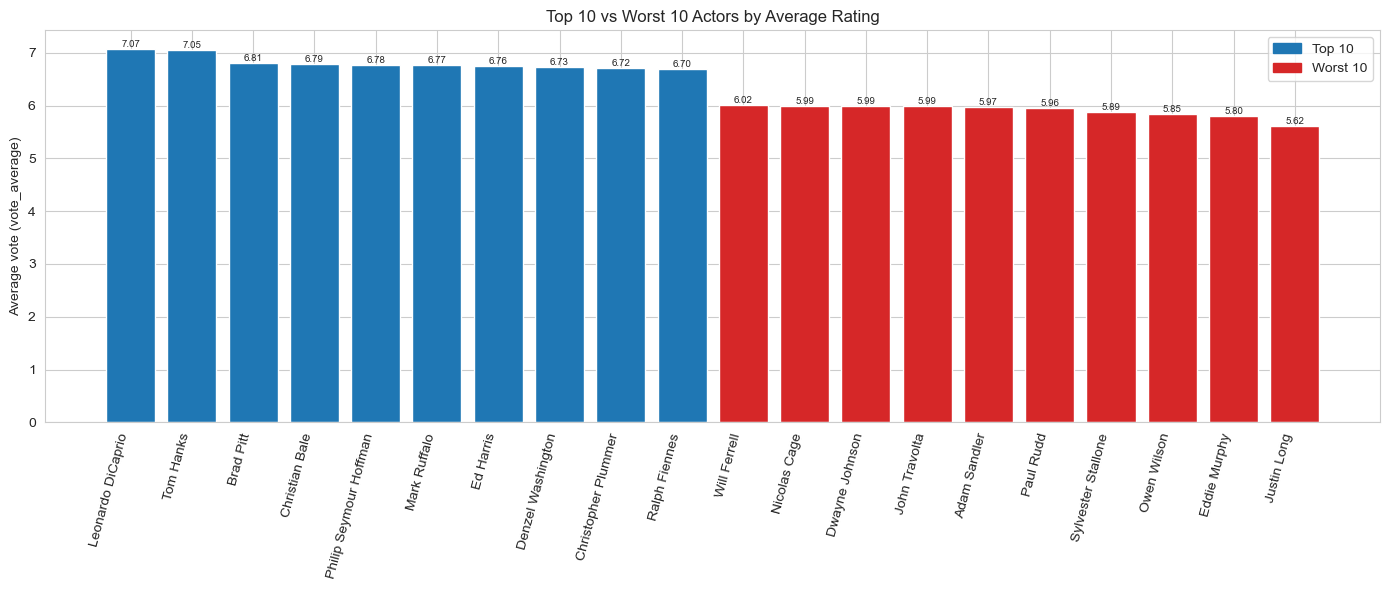

In [21]:
import matplotlib.pyplot as plt
import numpy as np

TOP_SHOW = 10

best10 = actor_stats.head(TOP_SHOW)
worst10 = actor_stats.tail(TOP_SHOW)

combined = pd.concat(
    [best10.assign(group="Top 10"), worst10.assign(group="Worst 10")],
    axis=0
)

combined = combined.reset_index(drop=True)

colors = ["tab:blue" if g == "Top 10" else "tab:red" for g in combined["group"]]

plt.figure(figsize=(14, 6))
bars = plt.bar(combined["actor_name"], combined["mean_rating"], color=colors)

plt.xticks(rotation=75, ha="right")
plt.ylabel("Average vote (vote_average)")
plt.title("Top 10 vs Worst 10 Actors by Average Rating")

for bar, val in zip(bars, combined["mean_rating"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=7,
    )

from matplotlib.patches import Patch
legend_handles = [
    Patch(color="tab:blue", label="Top 10"),
    Patch(color="tab:red", label="Worst 10"),
]
plt.legend(handles=legend_handles, loc="best")

plt.tight_layout()
plt.show()


It is clear that the movie rating is greatly influenced by the top five casts of the movie, making it a natural design to include top 5 actors as a part of the feature

#### Exploratory Data Analysis - Spearman Correlation Analysis:
We compute Spearman correlation coefficients to measure monotonic relationships between features and ratings. Unlike Pearson correlation, Spearman can capture non-linear monotonic relationships and is less sensitive to outliers.

=== Spearman Correlation with vote_average (sorted) ===
vote_average                1.000000
runtime                     0.398553
popularity                  0.360048
num_keywords                0.327981
num_cast                    0.251736
revenue                     0.244019
num_crew                    0.218832
num_spoken_languages        0.121770
num_production_companies    0.112234
num_production_countries    0.099928
budget                      0.066114
num_genres                  0.023319
Name: vote_average, dtype: float64


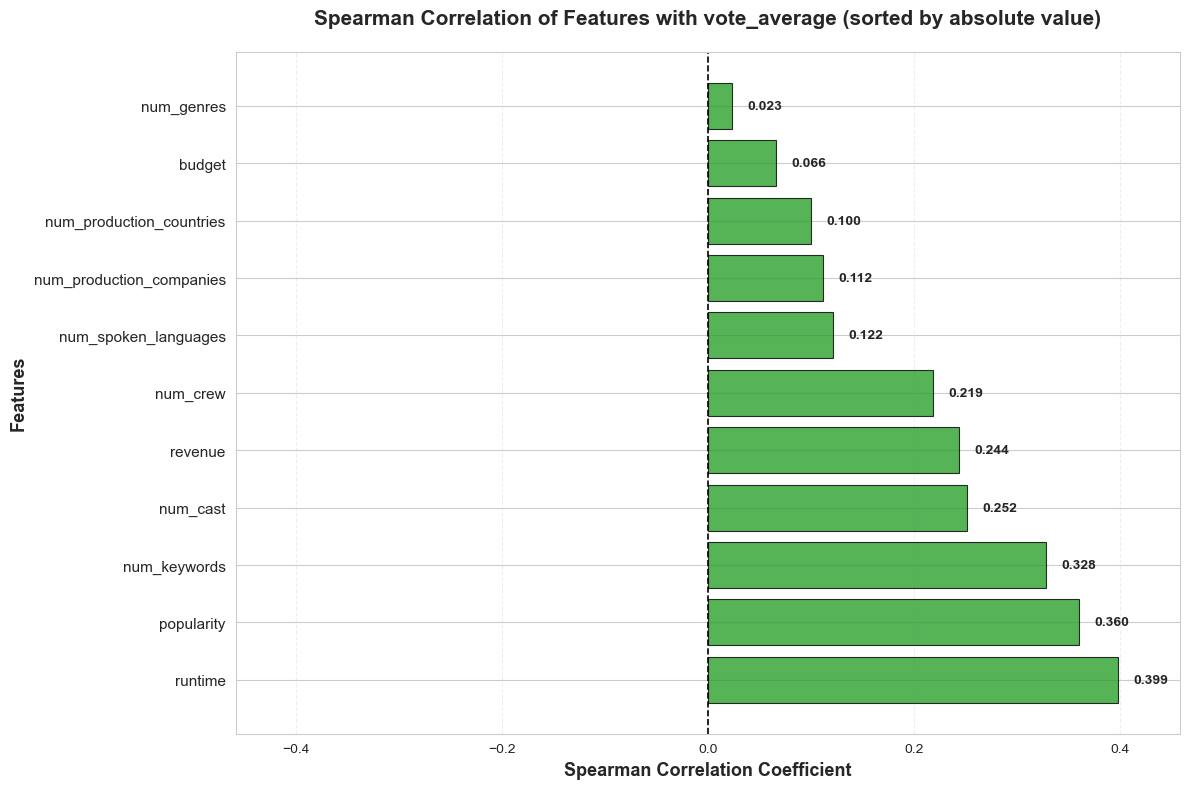

In [14]:
numerical_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'num_genres', 'num_keywords', 'num_production_companies',
                      'num_production_countries', 'num_spoken_languages',
                      'num_cast', 'num_crew', 'vote_average']

corr_df = df[numerical_features].corr(method='spearman') # spearman correlation

vote_corr = corr_df['vote_average'].sort_values(ascending=False)
print("=== Spearman Correlation with vote_average (sorted) ===")
print(vote_corr)

# Create a more visually appealing plot - sort by absolute value to show strongest correlations first
vote_corr_without_self = vote_corr.drop('vote_average')
vote_corr_sorted = vote_corr_without_self.reindex(vote_corr_without_self.abs().sort_values(ascending=False).index)

plt.figure(figsize=(12, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in vote_corr_sorted.values]
bars = plt.barh(range(len(vote_corr_sorted)), vote_corr_sorted.values,
                color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, vote_corr_sorted.values)):
    plt.text(value + (0.015 if value >= 0 else -0.015), bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center',
             fontsize=10, fontweight='bold')

plt.yticks(range(len(vote_corr_sorted)), vote_corr_sorted.index, fontsize=11)
plt.xticks(fontsize=10)
plt.xlabel('Spearman Correlation Coefficient', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('Spearman Correlation of Features with vote_average (sorted by absolute value)',
          fontsize=15, fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.2)
plt.grid(axis='x', alpha=0.3, linestyle='--')
# Set xlim to accommodate both positive and negative values
x_max = max(abs(vote_corr_sorted.min()), abs(vote_corr_sorted.max()))
plt.xlim(-x_max * 1.15, x_max * 1.15)
plt.tight_layout()
plt.show()

Spearman correlation results show that all features have positive monotonic relationships with vote_average. Runtime (0.399) and popularity (0.360) demonstrate the strongest associations, while content richness features (num_keywords, num_cast, num_crew) show moderate positive correlations. The pattern is consistent with Pearson correlation, confirming robust relationships between these features and movie ratings. Budget and num_genres have the weakest associations, suggesting limited predictive value.

### **Prompt LLM Preprocess**
#### Prepare Final Text Input for Large Language Model Input:
We convert each movie's structured data into a formatted text string that serves as input for the language model. This text includes key information such as title, budget, revenue, runtime, popularity, keywords, genres, cast, director, production details, and overview. The structured format allows the model to process all relevant features as natural language, enabling it to learn patterns and relationships for predicting movie ratings.

In [28]:
def extract_name_list(obj, key="name"):
    if not obj:
        return []
    return [d.get(key, "") for d in obj if isinstance(d, dict) and d.get(key)]

def row_to_text(row):
    title = row.get("title", "")

    kw_list = extract_name_list(safe_parse_json(row["keywords"]))
    keywords_text = ", ".join(kw_list) if kw_list else "None"

    prod_companies_list = extract_name_list(safe_parse_json(row["production_companies"]))
    prod_companies_text = ", ".join(prod_companies_list) if prod_companies_list else "None"

    prod_countries_list = extract_name_list(safe_parse_json(row["production_countries"]))
    prod_countries_text = ", ".join(prod_countries_list) if prod_countries_list else "None"

    cast_list = extract_name_list(safe_parse_json(row["cast"]))
    cast_text = ", ".join(cast_list[:10]) if cast_list else "None"

    directors = row.get("director", []) or []
    if isinstance(directors, str):
        directors = [directors]
    director_text = ", ".join(directors) if directors else "None"

    genres = row.get("genre_list", []) or []
    genres_text = ", ".join(genres) if genres else "None"

    return (
        f"Title: {title}\n"
        f"Budget: {row['budget']}, revenue: {row['revenue']}, "
        f"runtime: {row['runtime']} minutes, popularity: {row['popularity']}.\n"
        f"Keywords: {keywords_text}.\n"
        f"Original language: {row['original_language']}.\n"
        f"Status: {row['status']}.\n"
        f"Genres: {genres_text}.\n"
        f"Cast: {cast_text}.\n"
        f"Director: {director_text}.\n"
        f"Production companies: {prod_companies_text}.\n"
        f"Production countries: {prod_countries_text}.\n"
        f"Number of cast: {row['num_cast']}, "
        f"number of crew: {row['num_crew']}, "
        f"Overview: {row['overview']}\n"
    )

df["lm_input"] = df.apply(row_to_text, axis=1)

In [29]:
from sklearn.model_selection import train_test_split

data = df.copy()
train_df, temp_df = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    shuffle=True,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape)
print(train_df.columns)

(3360, 31)
Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'vote_average', 'vote_count', 'cast',
       'crew', 'title', 'num_genres', 'num_keywords',
       'num_production_companies', 'num_production_countries',
       'num_spoken_languages', 'num_cast', 'num_crew', 'director', 'top_cast',
       'genre_list', 'lm_input'],
      dtype='object')


### **Similarity-Based Preprocess**

### Build the feature vectors for each movie

- Overview text is converted into a binary bag-of-words representation of the top N words.  
- Numeric fields are standardized and added as scalar features.  **budget**, **popularity**, **runtime**
- Cast information uses a one-hot vector of the top N most frequent actors.  
- Genre list is transformed into a one-hot vector of the top N genres.  
- Director column becomes a one-hot vector of the top D directors.  
- Original language becomes a one-hot vector of the top L languages.  

All feature blocks are concatenated into a single sparse matrix representing each movie.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

TOP_N_ACTORS = 100
TOP_N_GENRES = 20
TOP_N_DIRECTORS = 50
TOP_N_LANGUAGES = 10


def build_cast_features(train_df, val_df, test_df, top_n_actors=TOP_N_ACTORS):
    all_cast = (
        pd.concat(
            [
                train_df[["top_cast"]],
                val_df[["top_cast"]],
                test_df[["top_cast"]],
            ],
            axis=0,
            ignore_index=True,
        )
        .explode("top_cast")
        .dropna(subset=["top_cast"])
    )

    actor_counts = all_cast["top_cast"].value_counts()
    top_actor_names = list(actor_counts.head(top_n_actors).index)
    actor_to_idx = {name: i for i, name in enumerate(top_actor_names)}

    def make_matrix(df):
        n = len(df)
        mat = np.zeros((n, len(top_actor_names)), dtype=np.float32)
        for i, cast_list in enumerate(df["top_cast"].values):
            if isinstance(cast_list, list):
                for name in cast_list:
                    j = actor_to_idx.get(name)
                    if j is not None:
                        mat[i, j] = 1.0
        return csr_matrix(mat)

    X_train = make_matrix(train_df)
    X_val = make_matrix(val_df)
    X_test = make_matrix(test_df)

    feature_names = np.array([f"cast__{name}" for name in top_actor_names])
    return (X_train, X_val, X_test), feature_names


def build_genre_features(train_df, val_df, test_df, top_n_genres=TOP_N_GENRES):
    all_genres = (
        pd.concat(
            [
                train_df[["genre_list"]],
                val_df[["genre_list"]],
                test_df[["genre_list"]],
            ],
            axis=0,
            ignore_index=True,
        )
        .explode("genre_list")
        .dropna(subset=["genre_list"])
    )

    genre_counts = all_genres["genre_list"].value_counts()
    total_genres = len(genre_counts)
    print(f"Total unique genres in dataset: {total_genres}")

    top_genre_names = list(genre_counts.head(top_n_genres).index)
    genre_to_idx = {g: i for i, g in enumerate(top_genre_names)}

    def make_matrix(df):
        n = len(df)
        mat = np.zeros((n, len(top_genre_names)), dtype=np.float32)
        for i, g_list in enumerate(df["genre_list"].values):
            if isinstance(g_list, list):
                for g in g_list:
                    j = genre_to_idx.get(g)
                    if j is not None:
                        mat[i, j] = 1.0
        return csr_matrix(mat)

    X_train = make_matrix(train_df)
    X_val = make_matrix(val_df)
    X_test = make_matrix(test_df)

    feature_names = np.array([f"genre__{g}" for g in top_genre_names])
    return (X_train, X_val, X_test), feature_names


def build_director_features(
    train_df,
    val_df,
    test_df,
    top_n_directors=TOP_N_DIRECTORS,
):
    all_directors = (
        pd.concat(
            [
                train_df[["director"]],
                val_df[["director"]],
                test_df[["director"]],
            ],
            axis=0,
            ignore_index=True,
        )
        .explode("director")
        .dropna(subset=["director"])
    )

    director_counts = all_directors["director"].value_counts()
    total_directors = len(director_counts)
    print(f"Total unique directors in dataset: {total_directors}")

    top_director_names = list(director_counts.head(top_n_directors).index)
    director_to_idx = {d: i for i, d in enumerate(top_director_names)}

    def make_matrix(df):
        n = len(df)
        mat = np.zeros((n, len(top_director_names)), dtype=np.float32)
        for i, d_list in enumerate(df["director"].values):
            if isinstance(d_list, list):
                for d in d_list:
                    j = director_to_idx.get(d)
                    if j is not None:
                        mat[i, j] = 1.0
        return csr_matrix(mat)

    X_train = make_matrix(train_df)
    X_val = make_matrix(val_df)
    X_test = make_matrix(test_df)

    feature_names = np.array([f"director__{d}" for d in top_director_names])
    return (X_train, X_val, X_test), feature_names


def build_language_features(
    train_df,
    val_df,
    test_df,
    top_n_languages=TOP_N_LANGUAGES,
):
    all_lang = pd.concat(
        [
            train_df[["original_language"]],
            val_df[["original_language"]],
            test_df[["original_language"]],
        ],
        axis=0,
        ignore_index=True,
    )["original_language"].dropna()

    lang_counts = all_lang.value_counts()
    total_langs = len(lang_counts)
    print(f"Total unique original languages in dataset: {total_langs}")

    top_lang_names = list(lang_counts.head(top_n_languages).index)
    lang_to_idx = {l: i for i, l in enumerate(top_lang_names)}

    def make_matrix(df):
        n = len(df)
        mat = np.zeros((n, len(top_lang_names)), dtype=np.float32)
        langs = df["original_language"].fillna("").values
        for i, l in enumerate(langs):
            j = lang_to_idx.get(l)
            if j is not None:
                mat[i, j] = 1.0
        return csr_matrix(mat)

    X_train = make_matrix(train_df)
    X_val = make_matrix(val_df)
    X_test = make_matrix(test_df)

    feature_names = np.array([f"lang__{l}" for l in top_lang_names])
    return (X_train, X_val, X_test), feature_names


def build_overview_features(train_df, val_df, test_df, max_features=500):
    vectorizer = CountVectorizer(
        max_features=max_features,
        binary=True,
        stop_words="english",
    )
    X_train = vectorizer.fit_transform(train_df["overview"])
    X_val = vectorizer.transform(val_df["overview"])
    X_test = vectorizer.transform(test_df["overview"])
    words = vectorizer.get_feature_names_out()
    feature_names = np.array([f"overview__{w}" for w in words])
    return (X_train, X_val, X_test), feature_names, vectorizer


def build_numeric_features(train_df, val_df, test_df, cols):
    # If a numeric col is missing, fill with 0 (already preprocessed conceptually)
    for col in cols:
        if col not in train_df.columns:
            train_df[col] = 0.0
            val_df[col] = 0.0
            test_df[col] = 0.0

    numeric_train = train_df[cols].fillna(0.0).values.astype(float)
    numeric_val = val_df[cols].fillna(0.0).values.astype(float)
    numeric_test = test_df[cols].fillna(0.0).values.astype(float)

    scaler = StandardScaler()
    numeric_train_scaled = scaler.fit_transform(numeric_train)
    numeric_val_scaled = scaler.transform(numeric_val)
    numeric_test_scaled = scaler.transform(numeric_test)

    X_train = csr_matrix(numeric_train_scaled)
    X_val = csr_matrix(numeric_val_scaled)
    X_test = csr_matrix(numeric_test_scaled)
    feature_names = np.array(cols)
    return (X_train, X_val, X_test), feature_names, scaler



In [34]:
def build_features(
    train_df,
    val_df,
    test_df,
    max_overview_features,
    numeric_cols,
    use_overview=False,
    use_cast=True,
    use_genre=True,
    use_director=False,
    use_language=False,
    top_n_actors=TOP_N_ACTORS,
    top_n_genres=TOP_N_GENRES,
    top_n_directors=TOP_N_DIRECTORS,
    top_n_languages=TOP_N_LANGUAGES,
    verbose=False,
):
    feature_blocks_train = []
    feature_blocks_val = []
    feature_blocks_test = []
    feature_name_blocks = []

    # Text features (overview)
    if use_overview:
        (
            overview_train,
            overview_val,
            overview_test,
        ), overview_feature_names, overview_vectorizer = build_overview_features(
            train_df,
            val_df,
            test_df,
            max_features=max_overview_features,
        )
        feature_blocks_train.append(overview_train)
        feature_blocks_val.append(overview_val)
        feature_blocks_test.append(overview_test)
        feature_name_blocks.append(overview_feature_names)

    # Numeric features
    if len(numeric_cols) > 0:
        (
            numeric_train_sparse,
            numeric_val_sparse,
            numeric_test_sparse,
        ), numeric_feature_names, numeric_scaler = build_numeric_features(
            train_df,
            val_df,
            test_df,
            numeric_cols,
        )
        feature_blocks_train.append(numeric_train_sparse)
        feature_blocks_val.append(numeric_val_sparse)
        feature_blocks_test.append(numeric_test_sparse)
        feature_name_blocks.append(numeric_feature_names)
    else:
        numeric_feature_names = np.array([])

    # Cast one-hot features
    if use_cast:
        (cast_train, cast_val, cast_test), cast_feature_names = build_cast_features(
            train_df,
            val_df,
            test_df,
            top_n_actors=top_n_actors,
        )
        feature_blocks_train.append(cast_train)
        feature_blocks_val.append(cast_val)
        feature_blocks_test.append(cast_test)
        feature_name_blocks.append(cast_feature_names)
    else:
        cast_feature_names = np.array([])

    # Genre one-hot features
    if use_genre:
        (
            genre_train,
            genre_val,
            genre_test,
        ), genre_feature_names = build_genre_features(
            train_df,
            val_df,
            test_df,
            top_n_genres=top_n_genres,
        )
        feature_blocks_train.append(genre_train)
        feature_blocks_val.append(genre_val)
        feature_blocks_test.append(genre_test)
        feature_name_blocks.append(genre_feature_names)
    else:
        genre_feature_names = np.array([])

    # Director one-hot features
    if use_director:
        (
            director_train,
            director_val,
            director_test,
        ), director_feature_names = build_director_features(
            train_df,
            val_df,
            test_df,
            top_n_directors=top_n_directors,
        )
        feature_blocks_train.append(director_train)
        feature_blocks_val.append(director_val)
        feature_blocks_test.append(director_test)
        feature_name_blocks.append(director_feature_names)
    else:
        director_feature_names = np.array([])

    # Original language one-hot features
    if use_language:
        (
            lang_train,
            lang_val,
            lang_test,
        ), language_feature_names = build_language_features(
            train_df,
            val_df,
            test_df,
            top_n_languages=top_n_languages,
        )
        feature_blocks_train.append(lang_train)
        feature_blocks_val.append(lang_val)
        feature_blocks_test.append(lang_test)
        feature_name_blocks.append(language_feature_names)
    else:
        language_feature_names = np.array([])

    # Combine all blocks
    X_train = hstack(feature_blocks_train).tocsr()
    X_val = hstack(feature_blocks_val).tocsr()
    X_test = hstack(feature_blocks_test).tocsr()

    feature_names = np.concatenate(feature_name_blocks)

    y_train = train_df["vote_average"].values
    y_val = val_df["vote_average"].values
    y_test = test_df["vote_average"].values

    global_mean_rating = y_train.mean()

    if verbose:
        print("X_train shape:", X_train.shape)
        print("X_val shape:", X_val.shape)
        print("X_test shape:", X_test.shape)
        print()
        print("Total number of features:", X_train.shape[1])
        print("Number of text features:", len(overview_feature_names))
        print("Number of numeric features:", len(numeric_feature_names))
        print("Number of cast features:", len(cast_feature_names))
        print("Number of genre features:", len(genre_feature_names))
        print("Number of director features:", len(director_feature_names))
        print("Number of language features:", len(language_feature_names))
        print()
        print("First 20 feature names:")
        print(feature_names[:20])

    return {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "overview_train": overview_train,
        "overview_val": overview_val,
        "overview_test": overview_test,
        "feature_names": feature_names,
        "overview_feature_names": overview_feature_names,
        "numeric_feature_names": numeric_feature_names,
        "cast_feature_names": cast_feature_names,
        "genre_feature_names": genre_feature_names,
        "director_feature_names": director_feature_names,
        "language_feature_names": language_feature_names,
        "overview_vectorizer": overview_vectorizer,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "global_mean_rating": global_mean_rating,
    }


In [36]:
feats = build_features(
    train_df,
    val_df,
    test_df,
    max_overview_features=200,
    numeric_cols=["budget", "popularity", "runtime"],
    use_overview=True,
    use_cast=True,
    use_genre=True,
    use_director=True,
    use_language=True,
    verbose=True
)


Total unique genres in dataset: 20
Total unique directors in dataset: 2574
Total unique original languages in dataset: 37
X_train shape: (3360, 383)
X_val shape: (720, 383)
X_test shape: (720, 383)

Total number of features: 383
Number of text features: 200
Number of numeric features: 3
Number of cast features: 100
Number of genre features: 20
Number of director features: 50
Number of language features: 10

First 20 feature names:
['overview__accident' 'overview__action' 'overview__adventure'
 'overview__agent' 'overview__america' 'overview__american'
 'overview__angeles' 'overview__army' 'overview__attempt' 'overview__away'
 'overview__based' 'overview__battle' 'overview__beautiful'
 'overview__begin' 'overview__begins' 'overview__best' 'overview__big'
 'overview__black' 'overview__boy' 'overview__british']
